<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Параметры-для-запуска" data-toc-modified-id="Параметры-для-запуска-1">Параметры для запуска</a></span></li><li><span><a href="#Считывание-изображения" data-toc-modified-id="Считывание-изображения-2">Считывание изображения</a></span></li><li><span><a href="#Фильтрация-изображения" data-toc-modified-id="Фильтрация-изображения-3">Фильтрация изображения</a></span></li><li><span><a href="#Матрица-Гессе" data-toc-modified-id="Матрица-Гессе-4">Матрица Гессе</a></span></li><li><span><a href="#Построение-графа" data-toc-modified-id="Построение-графа-5">Построение графа</a></span><ul class="toc-item"><li><span><a href="#Выделение-сомы" data-toc-modified-id="Выделение-сомы-5.1">Выделение сомы</a></span></li><li><span><a href="#Определение-центра" data-toc-modified-id="Определение-центра-5.2">Определение центра</a></span></li><li><span><a href="#Добавление-точек-сомы-в-граф" data-toc-modified-id="Добавление-точек-сомы-в-граф-5.3">Добавление точек сомы в граф</a></span></li></ul></li><li><span><a href="#Расчет-путей" data-toc-modified-id="Расчет-путей-6">Расчет путей</a></span></li><li><span><a href="#Расчет-встречаемости" data-toc-modified-id="Расчет-встречаемости-7">Расчет встречаемости</a></span></li><li><span><a href="#Фильтрация-точек-по-встречаемости" data-toc-modified-id="Фильтрация-точек-по-встречаемости-8">Фильтрация точек по встречаемости</a></span></li><li><span><a href="#Tree-creation" data-toc-modified-id="Tree-creation-9">Tree creation</a></span></li></ul></div>

In [78]:
import os
import sys

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
import cv2
import scipy
from scipy import ndimage as ndi
import numpy as np
import networkx as nx

In [4]:
import napari

In [5]:
from tqdm.auto import tqdm

In [6]:
import ccdb
import astromorpho as astro

Can't load imreg package, affine and homography registrations won't work


/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/czifile.py:146: UserWarning: ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  warnings.warn(
2022-05-18 13:37:12.762917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/levtg/astro-morpho/venv/lib/python3.10/site-packages/cv2/../../lib64:/home/levtg/v3d_external/v3d_main/common_lib/lib/
2022-05-18 13:37:12.762940: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dler

In [7]:
from networx2napari import draw_edges, draw_nodes

In [8]:
def weight_of_arr(a, b):
    dprod = np.einsum('...ij,...ij->...i', a, b)
    norm_a = np.linalg.norm(a, axis=-1)
    norm_b = np.linalg.norm(b, axis=-1)
    cos_dist = np.nan_to_num(dprod / ((norm_a * norm_b)), nan=0)
    cos_dist = 1 - cos_dist
    return np.abs(1 - cos_dist) * np.mean([norm_a, norm_b], axis=0)

In [9]:
def calc_edges(arr1, arr2, index1, index2):
    weights = weight_of_arr(arr1, arr2)
    weight = weights.ravel()
    li = threshold_li(weight)
    idx1 = [tuple(i) for i in index1.reshape((-1, index1.shape[-1]))[weight>li]]
    idx2 = [tuple(i) for i in index2.reshape((-1, index2.shape[-1]))[weight>li]]
    return zip(idx1, idx2, 1 - weight[weight>li])

In [10]:
def draw_nodes(pos, nodelist):
    return np.asarray([pos[n] for n in nodelist])

In [11]:
def count_points_paths(paths):
    acc = {}
    for path in paths:
        for n in path:
            if n in acc.keys():
                acc[n] += 1
            else:
                acc[n] = 1
    return acc

# Параметры для запуска

In [12]:
filename = '/home/levtg/astro-morpho/data/3wk-both1-grn-raw.pic'
verbose = True
sigma = 2

# Set false to start from console
HANDY = True

# Считывание изображения

In [13]:
stack, meta = ccdb.read_pic(filename)
dims = ccdb.get_axes(meta)
dims

[(0.06491228, "Microns'"), (0.06491228, "Microns'"), (0.3, "Microns'")]

In [14]:
if len(dims):
    zoom = dims[0][0]/dims[-1][0]
else:
    zoom = 4

clahe

In [15]:
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))

In [16]:
IMG_SHAPE = stack.shape
stack_flat = stack.reshape((IMG_SHAPE[0], -1))
img_flat = clahe.apply(stack_flat)
img = img_flat.reshape(IMG_SHAPE)

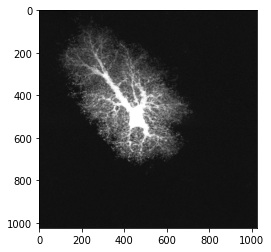

In [17]:
plt.imshow(img.max(0), cmap='gray')

In [18]:
img_noisy = ndi.zoom(img.astype(float),(1, zoom,zoom))

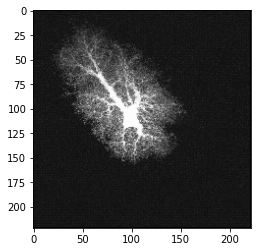

In [19]:
plt.imshow(img_noisy.max(0), cmap='gray')

In [20]:
napari.view_image(img_noisy)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 110.5, 110.5), zoom=8.13063063063063, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 77.0, 1.0), (0.0, 222.0, 1.0), (0.0, 222.0, 1.0)), current_step=(38, 111, 111), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'img_noisy' at 0x7f644a13a8f0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_vertices

# Фильтрация изображения

In [134]:
from skimage.filters import threshold_li, threshold_minimum
from skimage.morphology import remove_small_objects

In [138]:
def filter_image(image, filter_func):
    threshold = filter_func(image)
    img_filt = np.where(image > threshold, image, 0)
    napari.view_image(image >= threshold)
    binary_clean = remove_small_objects(image >= threshold, 5, connectivity=3)
    return np.where(binary_clean, img_filt, 0)

In [23]:
threshold = lambda x: 187

In [139]:
img_clear = filter_image(img_noisy, threshold_li)
if HANDY:
    img_clear = filter_image(img_noisy, threshold_minimum)

In [140]:
final_image = img_clear

In [142]:
w = napari.view_image(final_image)

# Матрица Гессе

In [199]:
if HANDY:
    sigma = 3

In [200]:
sato, Vf = astro.hessian.sato3d(final_image, sigma, hessian_variant='gradient_of_smoothed', return_vectors=True)

In [201]:
Vfx = Vf[...,0][...,::-1]
V = Vfx[..., 0]
U = Vfx[..., 1]
C = Vfx[..., 2]

In [202]:
lengths = astro.enh.percentile_rescale(sato)**0.5

In [203]:
vectors = np.stack((U*lengths, V*lengths, C*lengths), axis=3)

# Построение графа

In [204]:
crops = [((slice(1, None)), (slice(None, -1))),
         ((slice(1, None), slice(1, None), slice(1, None)), (slice(None, -1), slice(None, -1), slice(None, -1))),
         ((slice(1, None), slice(None, -1), slice(None, -1)), (slice(None, -1), slice(1, None), slice(1, None))),
         ((slice(1, None), slice(1, None)), (slice(None, -1), slice(None, -1))),
         ((slice(1, None), slice(None, -1)), (slice(None, -1), slice(1, None))),
         ((slice(1, None), slice(1, None), slice(None, -1)), (slice(None, -1), slice(None, -1), slice(1, None))),
         ((slice(1, None), slice(None, -1), slice(1, None)), (slice(None, -1), slice(1, None), slice(None, -1))),
         ((slice(1, None), slice(None), slice(None, -1)), (slice(None, -1), slice(None), slice(1, None))),
         ((slice(1, None), slice(None), slice(1, None)), (slice(None, -1), slice(None), slice(None, -1))),
         ((slice(None), slice(1, None), slice(1, None)), (slice(None), slice(None, -1), slice(None, -1))),
         ((slice(None), slice(1, None)), (slice(None), slice(None, -1))),
         ((slice(None), slice(1, None), slice(None, -1)), (slice(None), slice(None, -1), slice(1, None))),
         ((slice(None), slice(None), slice(None, -1)), (slice(None), slice(None), slice(1, None)))]

In [205]:
i, j, k = np.indices(vectors.shape[:-1])
idx = np.stack((i,j,k), axis=3)

In [206]:
G3 = nx.Graph()
nodes3 = {}

In [207]:
for crop, acrop in tqdm(crops):
    G3.add_weighted_edges_from(calc_edges(vectors[crop], vectors[acrop], idx[crop], idx[acrop]))

  0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_10930/1847692117.py:5: RuntimeWarning: invalid value encountered in true_divide
  cos_dist = np.nan_to_num(dprod / ((norm_a * norm_b)), nan=0)
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/skimage/filters/thresholding.py:757: RuntimeWarning: divide by zero encountered in log
  / (np.log(mean_back) - np.log(mean_fore)))


In [208]:

nodes3 = {n:n for n in G3.nodes()}

## Выделение сомы

In [209]:
from skimage.morphology import erosion, dilation

In [210]:
to_erose = final_image[:]

In [211]:
for i in range(6):
    to_erose = erosion(to_erose)

In [212]:
eroded = remove_small_objects(to_erose > 0, 5, connectivity=3)

In [213]:
soma_mask = np.where(dilation(eroded), True, False)

In [214]:
if verbose:
    w.add_image(soma_mask, blending='additive', colormap='cyan')

In [215]:
soma = [tuple(i) for i in idx[soma_mask]]

## Определение центра

In [216]:
import itertools as itt

In [217]:
def percentile_rescale(arr, plow=1, phigh=99.5):
    low, high = np.percentile(arr, (plow, phigh))
    if low == high:
        return np.zeros_like(arr)
    else:
        return np.clip((arr-low)/(high-low), 0, 1)

In [218]:
zstack = final_image[:]

In [219]:
%time X = np.array(list(itt.product(*map(range, zstack.shape))))

CPU times: user 1.79 s, sys: 104 ms, total: 1.9 s
Wall time: 1.9 s


In [220]:
weights_s = percentile_rescale(np.ravel(ndi.gaussian_filter(zstack,5))**2,plow=99.5,phigh=99.99)

In [221]:
center = tuple(map(int, np.sum(X*weights_s[:,None],axis=0)/np.sum(weights_s)))
center

(49, 107, 98)

## Добавление точек сомы в граф

In [222]:
G = nx.complete_graph(soma)

In [223]:
nx.set_edge_attributes(G, 0.7, name='weight')

In [224]:
for p1, p2, weight in G.edges(data=True):
    try:
        old_weight = G3.get_edge_data(p1, p2)['weight']
    except:
        old_weight = 1
    G3.add_edge(p1, p2, weight=min(weight['weight'], old_weight))

In [225]:
nodes3 = {n:n for n in G3.nodes()}

# Расчет путей

In [226]:
%time paths_dict = nx.single_source_dijkstra_path(G3, center)

CPU times: user 232 ms, sys: 108 µs, total: 232 ms
Wall time: 232 ms


In [227]:
paths = list(paths_dict.values())

In [228]:
np.save('{}_sigma{}_paths_all'.format(os.path.basename(filename), sigma), np.array(paths, dtype=object))

# Расчет встречаемости

In [229]:
points = count_points_paths(paths)

In [230]:
np.save('{}_sigma{}_points_count'.format(os.path.basename(filename), sigma), np.array(points, dtype=object))

In [231]:
if verbose:
    w.add_points(draw_nodes(nodes3, points), size=1, edge_color='transparent', face_color='b', name='count')

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [232]:
count_1 = []
for path in paths:
    count = 0
    for n in path:
        if points[n] == 1:
            count += 1
    count_1.append(count)

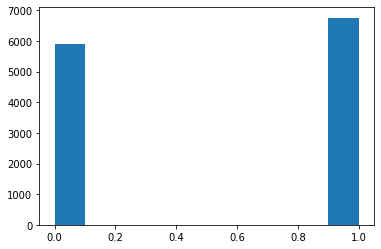

In [233]:
plt.hist(count_1)
plt.show()

In [234]:
to_del = []
for point, count in points.items():
    if count == 1:
        to_del.append(point)

# Фильтрация точек по встречаемости

In [235]:
from copy import copy
points_count = copy(points)

In [236]:
for point in to_del:
    del points_count[point]

In [237]:
sorted(points_count.values())[-20:]

[4889,
 4918,
 4941,
 4954,
 4959,
 4970,
 4977,
 4985,
 4986,
 5008,
 5022,
 6951,
 9426,
 9433,
 9438,
 9443,
 9449,
 9465,
 9478,
 12667]

In [238]:
del points_count[center]

In [239]:
if verbose:
    w.add_points(draw_nodes(nodes3, points_count), size=1, edge_color='transparent', face_color='r', name='count')

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [240]:
qstack = np.zeros(vectors.shape[:-1])
for loc, val in points_count.items():
    qstack[loc] = np.log(val)

In [241]:
if verbose:
    w.add_image(qstack)

In [242]:
p = np.asarray(list(points_count.keys()))

In [243]:
vals = np.asarray(list(points_count.values()))

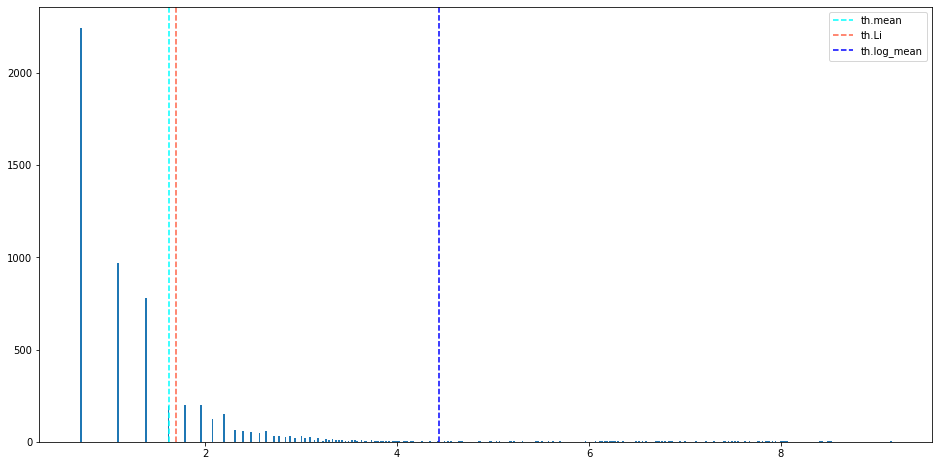

In [244]:
plt.figure(figsize=(16,8))
plt.hist(np.log(vals[vals>1]), bins=500)
#plt.xlim(-10, 100)
plt.axvline(np.mean(np.log(vals)), color='cyan', ls='--', label='th.mean')
plt.axvline(threshold_li(np.log(vals)), color='tomato', ls='--', label='th.Li')
plt.axvline(np.log(np.mean(vals)), color='b', ls='--', label='th.log_mean')
plt.legend()
plt.show()

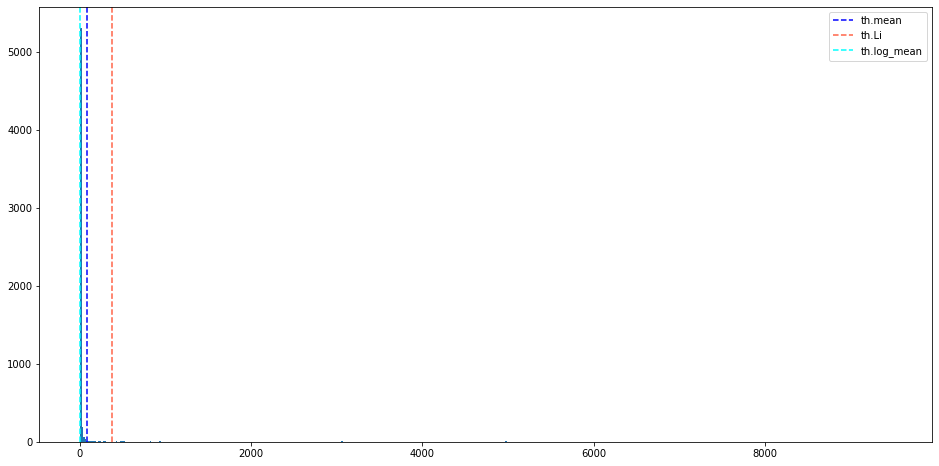

In [245]:
plt.figure(figsize=(16,8))
plt.hist(vals[vals>1], bins=500)
#plt.xlim(-10, 100)
plt.axvline(np.mean(vals), color='b', ls='--', label='th.mean')
plt.axvline(threshold_li(vals), color='tomato', ls='--', label='th.Li')
plt.axvline(np.exp(np.mean(np.log(vals))), color='cyan', ls='--', label='th.log_mean')
plt.legend()
plt.show()

In [246]:
points_mean = [k for k, v in points_count.items() if v > np.mean(vals)]
thr_li = threshold_li(vals)
points_li = [k for k, v in points_count.items() if v > thr_li]
# points_log_mean = [k for k, v in points_count.items() if np.log(v) > np.mean(np.log(vals))]
# points_log_li = [k for k, v in points_count.items() if np.log(v) > threshold_li(np.log(vals))]

In [247]:
if verbose:
    w.add_points(draw_nodes(nodes3, points_mean), size=1, edge_color='transparent', face_color='m', name='filt mean')
    w.add_points(draw_nodes(nodes3, points_li), size=1, edge_color='transparent', face_color='g', name='filt li')

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


# Tree creation

In [248]:
Gsub = G3.subgraph(points_mean)
nodes_sub = {n:n for n in Gsub.nodes()}

In [249]:
props = {'weight': 1 - np.array([edgedata["weight"] for _, _, edgedata in Gsub.edges(data=True)])}

In [194]:
w.add_shapes(draw_edges(nodes_sub, list(Gsub.edges())), shape_type='path', edge_color='weight', edge_width=0.1, edge_colormap='inferno', properties=props)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Shapes layer 'Shapes' at 0x7f634bc306d0>

In [255]:
from skimage.morphology import skeletonize, flood

In [196]:
skeleton = skeletonize(final_image/final_image.max())
w.add_image(skeleton, blending='additive', colormap='cyan')

<Image layer 'skeleton' at 0x7f634a811630>

In [260]:
flood_mask = flood(final_image > 0, center)
w.add_image(flood_mask, colormap='red', opacity=0.5)

<Image layer 'flood_mask' at 0x7f6354c250f0>

In [262]:
img = np.where(flood_mask, final_image/final_image.max(), 0)
skeleton_2 = skeletonize(img)
w.add_image(skeleton_2, blending='additive', colormap='cyan')

<Image layer 'skeleton_2' at 0x7f6361973f70>

In [197]:
from skimage.graph import pixel_graph

In [198]:
pixel_graph(skeleton)

(<3794868x3794868 sparse matrix of type '<class 'numpy.float64'>'
 	with 22602264 stored elements in Compressed Sparse Row format>,
 array([      0,       1,       2, ..., 3794865, 3794866, 3794867]))